# License Plate Detection

## Downloading the dataset

In [1]:
from datasets import load_dataset
ds = load_dataset("keremberke/license-plate-object-detection", name="full")
example = ds['train'][0]
example

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


{'image_id': 6152,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 'width': 472,
 'height': 303,
 'objects': {'id': [6388],
  'area': [2604],
  'bbox': [[261.0, 203.0, 93.0, 28.0]],
  'category': [0]}}

## Data Processing

In [ ]:
IMG_SIZE = 416
GRID_SIZE = 13
NUM_CLASSES = 1

import tensorflow as tf
import numpy as np

def utils_resize_with_pad(image, target_size):
    if not tf.is_tensor(image):
        image = tf.convert_to_tensor(image)
        
    shape = tf.cast(tf.shape(image), tf.float32)
    h, w = shape[0], shape[1]
    
    target_size_float = tf.cast(target_size, tf.float32)
    target_size_int = tf.cast(target_size, tf.int32)
    
    scale = tf.minimum(target_size_float / w, target_size_float / h)
    
    new_w = tf.cast(w * scale, tf.int32)
    new_h = tf.cast(h * scale, tf.int32)
    
    image = tf.image.resize(image, (new_h, new_w))
    
    image = tf.image.resize_with_pad(image, target_size_int, target_size_int)
    
    pad_w = (target_size_float - tf.cast(new_w, tf.float32)) / 2.0
    pad_h = (target_size_float - tf.cast(new_h, tf.float32)) / 2.0
    
    return image, scale, pad_w, pad_h

def preprocess(sample, augment=False):
    image = sample["image"]
    
    image = tf.convert_to_tensor(np.array(image))
    
    if augment:
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_saturation(image, 0.8, 1.2)


    image, scale, pad_w, pad_h = utils_resize_with_pad(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0

    target = np.zeros((GRID_SIZE, GRID_SIZE, 5), dtype=np.float32)

    boxes = sample["objects"]["bbox"]

    for box in boxes:
        x, y, w, h = box
        
        x = x * scale
        y = y * scale
        w = w * scale
        h = h * scale
        
        x += pad_w
        y += pad_h
        
        xc = (x + w / 2) / IMG_SIZE
        yc = (y + h / 2) / IMG_SIZE
        w /= IMG_SIZE
        h /= IMG_SIZE

        if w > 0 and h > 0:
            gx = int(xc * GRID_SIZE)
            gy = int(yc * GRID_SIZE)

            if 0 <= gx < GRID_SIZE and 0 <= gy < GRID_SIZE:
                target[gy, gx, 0] = 1.0        # objectness
                
                # relative
                xc_rel = xc * GRID_SIZE - gx
                yc_rel = yc * GRID_SIZE - gy
                
                target[gy, gx, 1:] = [xc_rel, yc_rel, w, h]

    return image, target

## Data Loading

In [3]:
BATCH_SIZE = 8

def tf_generator(split, augment=False):
    for sample in ds[split]:
        yield preprocess(sample, augment=augment)

output_signature = (
    tf.TensorSpec((IMG_SIZE, IMG_SIZE, 3), tf.float32),
    tf.TensorSpec((GRID_SIZE, GRID_SIZE, 5), tf.float32)
)

train_ds = tf.data.Dataset.from_generator(
    lambda: tf_generator("train", augment=True),
    output_signature=output_signature
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model

In [ ]:
from tensorflow.keras import layers, models

def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = layers.Conv2D(16, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(5, 1, activation=None)(x)
    outputs = layers.Reshape((GRID_SIZE, GRID_SIZE, 5))(x)

    return models.Model(inputs, outputs)

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 416, 416, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 416, 416, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 416, 416, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 416, 416, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 208, 208, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 208, 208, 32)   │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 208, 208, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 208, 208, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 104, 104, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 104, 104, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 104, 104, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 104, 104, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 52, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 52, 52, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 5)      │         1,285 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 395,381 (1.51 MB)

 Trainable params: 394,389 (1.50 MB)

 Non-trainable params: 992 (3.88 KB)

## Training

In [ ]:
def detection_loss(y_true, y_pred):
    obj_mask = y_true[..., 0]
    noobj_mask = 1.0 - obj_mask

    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    obj_loss_map = bce(y_true[..., 0:1], y_pred[..., 0:1])
    
    obj_loss = tf.reduce_sum(obj_mask * obj_loss_map) + 0.5 * tf.reduce_sum(noobj_mask * obj_loss_map)

    box_diff = y_true[..., 1:] - tf.sigmoid(y_pred[..., 1:])
    box_loss_map = tf.reduce_sum(tf.square(box_diff), axis=-1)
    
    box_loss = tf.reduce_sum(obj_mask * box_loss_map)
    
    batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
    
    return (obj_loss + 5.0 * box_loss) / batch_size

In [6]:
model = build_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=detection_loss
)

history = model.fit(train_ds, epochs=10)

# Save the model
model.save("license_plate_detector.keras")

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/numpy/_core/getlimits.py:552: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.12/dist-packages/numpy/_core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


772/772 ━━━━━━━━━━━━━━━━━━━━ 189s 231ms/step - loss: 7.8350
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


772/772 ━━━━━━━━━━━━━━━━━━━━ 173s 224ms/step - loss: 1.3912
Epoch 3/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 172s 222ms/step - loss: 1.0715
Epoch 4/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 168s 217ms/step - loss: 0.8986
Epoch 5/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 170s 220ms/step - loss: 0.7786
Epoch 6/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 200s 218ms/step - loss: 0.6491
Epoch 7/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 167s 217ms/step - loss: 0.5554
Epoch 8/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 172s 222ms/step - loss: 0.4904
Epoch 9/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 171s 222ms/step - loss: 0.4226
Epoch 10/10
772/772 ━━━━━━━━━━━━━━━━━━━━ 169s 219ms/step - loss: 0.3648


# Inference test

In [ ]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

OBJ_THRESHOLD = 0.5 

def infer_single_image(model, sample, expand_box_ratio=0.15):

    image = sample["image"]
    
    img_tensor, scale, pad_w, pad_h = utils_resize_with_pad(image, IMG_SIZE)
    img_tensor = tf.cast(img_tensor, tf.float32) / 255.0

    pred = model(tf.expand_dims(img_tensor, 0), training=False)

    obj = tf.sigmoid(pred[0, ..., 0])
    box = tf.sigmoid(pred[0, ..., 1:5])

    max_idx = tf.argmax(tf.reshape(obj, [-1]))
    gy = max_idx // GRID_SIZE
    gx = max_idx % GRID_SIZE
    
    gy = int(gy)
    gx = int(gx)
    pad_w = float(pad_w)
    pad_h = float(pad_h)
    scale = float(scale)

    confidence = obj[gy, gx].numpy()

    if confidence < OBJ_THRESHOLD:
        return image, None, confidence

    x_rel, y_rel, w, h = box[gy, gx].numpy()

    xc = (gx + x_rel) / GRID_SIZE
    yc = (gy + y_rel) / GRID_SIZE
    
    xc_px = xc * IMG_SIZE
    yc_px = yc * IMG_SIZE
    w_px = w * IMG_SIZE
    h_px = h * IMG_SIZE
    
    xc_px -= pad_w
    yc_px -= pad_h
    
    xc_orig = xc_px / scale
    yc_orig = yc_px / scale
    w_orig = w_px / scale
    h_orig = h_px / scale
    
    w_orig *= (1 + expand_box_ratio)
    h_orig *= (1 + expand_box_ratio)
    
    x1 = xc_orig - w_orig / 2
    y1 = yc_orig - h_orig / 2
    x2 = xc_orig + w_orig / 2
    y2 = yc_orig + h_orig / 2
    
    orig_w, orig_h = image.size
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(orig_w, x2)
    y2 = min(orig_h, y2)

    return image, (x1, y1, x2, y2), confidence


def show_prediction(image, box, confidence):
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(image)
    ax.axis("off")

    if box is not None:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)
        ax.set_title(f"Confidence: {confidence:.2f}")
    else:
        ax.set_title("No detection")

    plt.show()

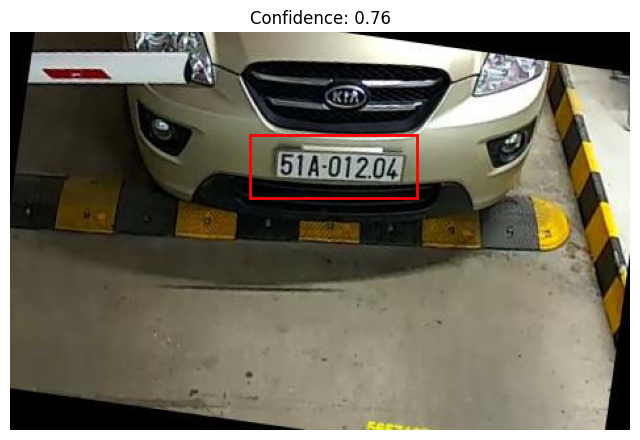

In [65]:
sample = random.choice(ds["test"])
image, box, conf = infer_single_image(model, sample)
show_prediction(image, box, conf)